In [ ]:
from torchvision import datasets
import torch

In [ ]:
# download the FMNIST training dataset
fmnist = datasets.FashionMNIST('~/data/FMNIST', download=True, train = True)

# fmnist validation dataset
val_fmnist = datasets.FashionMNIST('~/data/FMNIST', train = False)

100%|██████████| 26421880/26421880 [00:02<00:00, 12361317.24it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203144.24it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3872157.88it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20622996.17it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



In [ ]:
# training dataset
tr_images  = fmnist.data

# validation datasets
val_images = val_fmnist.data

# training labels
tr_targets = fmnist.targets

# validation labels
val_targets = val_fmnist.targets

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# build a class that fetch the dataset
class MyFMNISTDataset(Dataset):
    def __init__(self, x, y):
        
        # convert to float values, flatten
        # store them into the device
        x = x.float()/255.
        x = x.view(-1, 28*28)
        self.x = x.to(device)
        self.y = y.to(device)
        
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
    
    def __len__(self):
        return len(self.x)

In [ ]:
# build a function to fetch a batchsize from the dataset
def get_data():
    # fetch the training dataset and the batches from itself
    trn_dts = MyFMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(trn_dts, batch_size=32, shuffle=True)
    
    # fetch the validation dataset and the batches from itself
    val_dts = MyFMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val_dts, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

In [ ]:
from torch.optim import SGD, Adam

# define a model function
def get_model():
    class NeuralNetwork(nn.Module):
        def __init__(self):
            super().__init__()
            self.input_to_hidden_layer = nn.Linear(28*28, 1000)
            self.hidden_layer_activation = nn.ReLU()
            self.hidden_to_output_layer = nn.Linear(1000, 10)
        
        def forward(self, x):
            x0 = self.input_to_hidden_layer(x)
            x1 = self.hidden_layer_activation(x0)
            x2 = self.hidden_to_output_layer(x1)
            return x2, x1
            
    my_model = NeuralNetwork().to(device)
    
    #  Loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # optimizer
    optimizer = Adam(my_model.parameters(), lr = 0.001)
    
    return my_model, loss_fn, optimizer

In [ ]:
# function to train the dataset on a batch of images

# regularizer 
l1_lambd = 0.0001

def train_batch(batch_x, batch_y, my_model, loss_fn, optimizer):
    # train mode
    my_model.train()
    
    # add a regularization
    # torch.norm provide the absolute values of the weights and bias values
    l1_regularization = 0
    for params in my_model.parameters():
        l1_regularization += torch.norm(params, 1)
    
    # compute the batch loss
    batch_loss = loss_fn(my_model(batch_x)[0], batch_y) + l1_lambd*l1_regularization
    
    # backward pass
    batch_loss.backward()
    
    # update parameters
    optimizer.step()
    
    # flush the previous gradients
    optimizer.zero_grad()
    
    return batch_loss.item()

In [ ]:
@torch.no_grad()
def val_loss(val_batch_x, val_batch_y, my_model):
    # evaluation mode
    my_model.eval()
    
    # compute validation loss
    val_batch_loss = loss_fn(my_model(val_batch_x)[0], val_batch_y)
    return val_batch_loss.item()

In [ ]:
# compute the accuracy

# disable gradient computation in the whole function
@torch.no_grad()
def accuracy(batch_x, batch_y, my_model):
    
    # evaluation mode
    my_model.eval()
    
    # compute the max and the argmax
    max_values, argmaxes = my_model(batch_x)[0].max(-1)
    
    # coincide with ground truth
    is_correct = argmaxes == batch_y
    
    return is_correct.cpu().numpy().tolist()

In [ ]:
trn_dl, val_dl = get_data()
my_model, loss_fn, optimizer = get_model()

In [ ]:
import numpy as np
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 0, 
                                           threshold = 0.001, min_lr = 0.00001,
                                           threshold_mode='abs',
                                           verbose=True)
# empty list of the total losses
losses, accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(100):
    batch_losses, batch_accuracies = [], []
    
    for ix, (batch_x, batch_y) in enumerate(iter(trn_dl)):
        
        batch_loss = train_batch(batch_x, batch_y, my_model, loss_fn, optimizer)
        
        batch_losses.append(batch_loss)
    train_epoch_loss = np.array(batch_losses).mean()
    
    for ix, batches in enumerate(iter(trn_dl)):
        batch_x, batch_y = batches
        
        batch_accuracy = accuracy(batch_x, batch_y, my_model)
        
        batch_accuracies.extend(batch_accuracy)
    train_epoch_accuracy = np.array(batch_accuracies).mean()
    
    # Validation set
    for ix, (val_batch_x, val_batch_y) in enumerate(iter(val_dl)):
        val_batch_accuracies = accuracy(val_batch_x, val_batch_y, my_model)
        val_batch_loss = val_loss(val_batch_x, val_batch_y, my_model)
        scheduler.step(val_batch_loss)
    val_epoch_accuracy = np.array(val_batch_accuracies).mean()
        
    losses.append(train_epoch_loss)
    accuracies.append(train_epoch_accuracy)
    val_losses.append(val_batch_loss)
    val_accuracies.append(val_epoch_accuracy)
    print('Epoch =', str(epoch+1) + ' is done')

Epoch = 1 is done
Epoch = 2 is done
Epoch = 3 is done
Epoch 00004: reducing learning rate of group 0 to 8.0000e-04.
Epoch = 4 is done
Epoch = 5 is done
Epoch 00006: reducing learning rate of group 0 to 6.4000e-04.
Epoch = 6 is done
Epoch = 7 is done
Epoch = 8 is done
Epoch 00009: reducing learning rate of group 0 to 5.1200e-04.
Epoch = 9 is done
Epoch 00010: reducing learning rate of group 0 to 4.0960e-04.
Epoch = 10 is done
Epoch = 11 is done
Epoch 00012: reducing learning rate of group 0 to 3.2768e-04.
Epoch = 12 is done
Epoch 00013: reducing learning rate of group 0 to 2.6214e-04.
Epoch = 13 is done
Epoch = 14 is done
Epoch 00015: reducing learning rate of group 0 to 2.0972e-04.
Epoch = 15 is done
Epoch = 16 is done
Epoch 00017: reducing learning rate of group 0 to 1.6777e-04.
Epoch = 17 is done
Epoch 00018: reducing learning rate of group 0 to 1.3422e-04.
Epoch = 18 is done
Epoch 00019: reducing learning rate of group 0 to 1.0737e-04.
Epoch = 19 is done
Epoch = 20 is done
Epoch 000

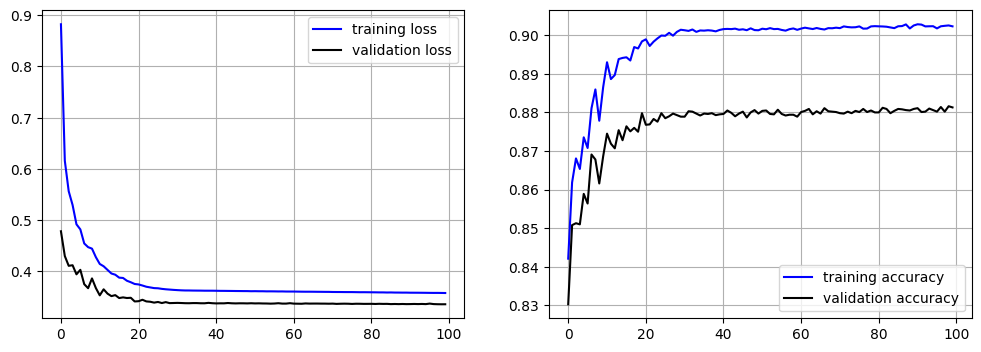

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(100), losses, c = 'blue', label = 'training loss')
plt.plot(range(100), val_losses, c = 'black', label = 'validation loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(100), accuracies, c = 'blue', label = 'training accuracy')
plt.plot(range(100), val_accuracies, c = 'black', label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [1]:
fig = plt.figure(figsize = (18, 8))

plt.subplot(2, 3, 1)
train_set = MyFMNISTDataset(tr_images, tr_targets)
plt.hist(my_model(train_set.x)[1].cpu().detach().numpy().flatten())
plt.grid(True)

for idx, params in enumerate(iter(my_model.parameters())):
    
    if idx == 0:
        # print('The weights of the first layer distribution : \n', params.cpu().detach().numpy())
        plt.subplot(2, 3, 2)
        plt.hist(params.cpu().detach().numpy().flatten())
        plt.grid(True)
        
    elif idx == 1:
        # print('The biases of the first layer distribution : \n', params.cpu().detach().numpy())
        plt.subplot(2, 3, 3)
        plt.hist(params.cpu().detach().numpy().flatten())
        plt.grid(True)
        
    elif idx == 2:
        # print('The weights of the output layer distribution : \n', params.cpu().detach().numpy())
        plt.subplot(2, 3, 5)
        plt.hist(params.cpu().detach().numpy().flatten())
        plt.grid(True)
      
    if idx == 3:
        # print('The biases of the output layer distribution : \n', params.cpu().detach().numpy())
        plt.subplot(2, 3, 6)
        plt.hist(params.cpu().detach().numpy().flatten())
        plt.grid(True)

NameError: ignored